In [1]:
import pymongo
import pandas as pd
import os
import seaborn as sns
# load environment variables from the server directory
from dotenv import load_dotenv
load_dotenv()  # take environment variables

True

In [2]:
# settings for the importation
# it is a good practice to create a dictionary to keep all settings in one place and then save it alongside the data
# "metadata" of the analysis
settings={
    "MONGODB_URI": os.getenv("MONGODB_URI"),
    "prolificStudyId": "686516a1e941c62a1108f7d8",
}


In [3]:
# open a connection to mongoDB running at the target URI
client = pymongo.MongoClient(settings["MONGODB_URI"])
# open the database "main" and the collection "RLWM"
db = client["main"]
collection=db["UserUnknown"]

In [ ]:
# load the .csv file obtained from prolific that contains all the subject of our experiment
df_demographics=pd.read_csv(f'demographics_from_prolific\prolific_export_{settings["prolificStudyId"]}.csv')

# get the list of prolificId (unique for each participant)
# except those who cancelled their participation (ie: RETURNED)
prolificId_list=df_demographics.loc[(df_demographics["Status"]!="RETURNED"), "Participant id"].to_list()


In [ ]:
#
df_group=pd.DataFrame()
# query the database to find all the documents of type "expdef" that contain a field named "prolificId" whose value exists in our prolificId_list
query = {
    "type": "expdef",
    "prolificId": {"$in": prolificId_list}
}
expdef_cursor = collection.find(query)
# get the experiment definition files one by one, for each subject
# this is going to be the main loop of our script in which we'll do (almost) everything
for expdef in expdef_cursor:
    # get stimuli and list of trials of the current subject
    # note that we use the function "find_one" we directly get the document rather than a cursor
    query = {
        "type": "stimdef",
        "prolificId": expdef["prolificId"],
    }
    stimdef = collection.find_one(query)
    # from stimdef, we reconstruct the list of trial definition performed by this participant
    trials_definition=[]
    for block in stimdef["blockTypes"]:
        if block["phase"]=="learn":
            for trial in block["trials"]:
                trials_definition.append(trial)
    df_trials_definition=pd.DataFrame(trials_definition)
    
    # get all the trials of each subject with the tag RLWMlearning (corresponding to moments where subject gave a response),
    # sorted by trialId (an integer), as a list
    # since we did not add prolificId to every single document, we look by sessionId (the most general identifier for our db)
    # session_id is also unique for each subject
    query = {
        "type": "trials",
        "subjectId": expdef["subjectId"],
        "trialTag": "RLWMlearning"
    }
    df_trials_data = pd.DataFrame(list(collection.find(query).sort("tNum",1)))
    if df_trials_data.shape[0]>400:
        #print(f'{expdef["prolificId"]} has {df_trials_data.shape[0]} trials')
        df_trials = pd.merge(df_trials_definition, df_trials_data, on='tNum', how='left')
        df_group=pd.concat([df_group,df_trials],axis=0,ignore_index=True).reset_index(drop=True)

In [ ]:
df_group['is_new_block'] = (df_group['tblockNum'] == 0).astype(int)

# Step 2: Mark where subjectId changes
df_group['is_new_subject'] = df_group['subjectId'] != df_group['subjectId'].shift()

# Step 3: Cumulative block numbering per subject
# Reset counter where subject changes
df_group['blockNum'] = (
    df_group.groupby('subjectId')['is_new_block']
    .cumsum()
    .where(~df_group['is_new_subject'])
    .fillna(0)
    .astype(int)
)

# Step 4: Count imgidx appearances within each block
df_group['blockRepeats'] = df_group.groupby(['subjectId', 'blockNum', 'imgIdx']).cumcount()

NameError: name 'plt' is not defined

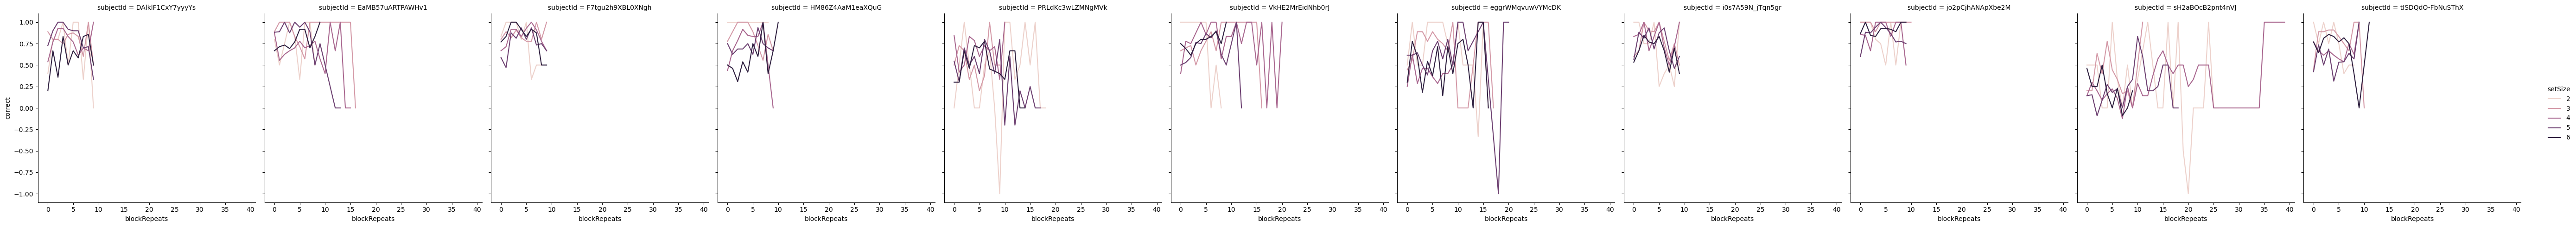

In [17]:
df_summary = (
    df_group.groupby(['blockRepeats', 'setSize', 'subjectId'])['correct']
    .mean()
    .reset_index()
)


# Plot with seaborn relplot
sns.relplot(
    data=df_summary,
    x='blockRepeats',
    y='correct',
    hue='setSize',
    kind='line',
    col='subjectId',
    facet_kws={'sharey': True, 'sharex': True}
)

plt.tight_layout()
plt.show()